In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Normalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

In [2]:
(tf.config.list_physical_devices())



[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [2]:
df_train = pd.read_csv('train.txt')
df_val = pd.read_csv('val.txt')
df_test = pd.read_csv('test.txt')

In [3]:
# train
df_train['X_real'] = df_train['Var1_2'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)').astype(float)
df_train['X_img'] = df_train['Var1_2'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)i').astype(float)
df_train['y_real'] = df_train['Var1_1'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)').astype(float)
df_train['y_img'] = df_train['Var1_1'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)i').astype(float)

# test
df_test['X_real'] = df_test['Var1_2'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)').astype(float)
df_test['X_img'] = df_test['Var1_2'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)i').astype(float)
df_test['y_real'] = df_test['Var1_1'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)').astype(float)
df_test['y_img'] = df_test['Var1_1'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)i').astype(float)

# val
df_val['X_real'] = df_val['Var1_2'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)').astype(float)
df_val['X_img'] = df_val['Var1_2'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)i').astype(float)
df_val['y_real'] = df_val['Var1_1'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)').astype(float)
df_val['y_img'] = df_val['Var1_1'].str.extract(r'([+-]?\d+\.\d+(?:[eE][+-]?\d+)?)i').astype(float)

In [4]:
X_train = df_train[['X_real','X_img']].to_numpy()
y_train = df_train[['y_real','y_img']].to_numpy()

X_test = df_test[['X_real','X_img']].to_numpy()
y_test = df_test[['y_real','y_img']].to_numpy()

X_val = df_val[['X_real','X_img']].to_numpy()
y_val = df_val[['y_real','y_img']].to_numpy()

In [5]:
def preprocess(arr, n_previous = 6):
    array_with_l1_norm  = np.hstack((arr, np.sum(np.abs(arr),axis=1)[:, np.newaxis]))

    padding = np.zeros((n_previous, array_with_l1_norm.shape[1]))
    padded_array = np.vstack((padding, array_with_l1_norm ))

    windows = sliding_window_view(padded_array, window_shape=(n_previous + 1, array_with_l1_norm.shape[1]))
    windows = windows.reshape(windows.shape[0], -1)
    
    return windows

In [6]:
X_train = preprocess(X_train)
X_test = preprocess(X_test)
X_val = preprocess(X_val)


In [7]:
X_train.shape

(131520, 21)

In [8]:
# from sklearn import preprocessing

# x_min_max_scaler = preprocessing.MinMaxScaler()
# y_min_max_scaler = preprocessing.MinMaxScaler()

# X_train = x_min_max_scaler.fit_transform(X_train)
# y_train = y_min_max_scaler.fit_transform(y_train)


In [9]:
# X_val = x_min_max_scaler.transform(X_val)
# y_val = y_min_max_scaler.transform(y_val)

# X_test = x_min_max_scaler.transform(X_test)
# y_test = y_min_max_scaler.transform(y_test)

In [10]:
# # Build the model using Sequential API
# model = Sequential([
#     Dense(30),
#     LeakyReLU(alpha=0.01),
#     Dense(30),
#     LeakyReLU(alpha=0.01),
#     Dense(30),
#     LeakyReLU(alpha=0.01),
#     Dense(2)
# ])

# # Compile the model
# model.compile(optimizer=Adam(learning_rate=4e-4), 
#               loss='mean_squared_error', 
#               metrics=['mean_squared_error'])

# # Define training parameters
# maxEpochs = 200
# miniBatchSize = 1024
# iterPerEpoch = len(X_train) // miniBatchSize
# validation_freq = 2 * iterPerEpoch

# # Callbacks for learning rate adjustment, early stopping, and model checkpoint
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=5, verbose=1, mode='auto')
# # early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# # Train the model
# history = model.fit(
#     X_train, y_train,
#     epochs=maxEpochs,
#     batch_size=miniBatchSize,
#     validation_data=(X_val, y_val),
#     callbacks=[reduce_lr],
#     shuffle=True,
#     verbose=1
# )

In [11]:
def helperNMSE(y_true, y_pred):
    
    diff = y_pred - y_true
    mse = tf.reduce_mean(tf.norm(diff,axis=1)**2) # NOTE THIS IS NOT A GOOD PRACICE AS TF.NORM ALREADY GETS THE SQUARED ERROR THEN SQRT IT
    factor = tf.reduce_mean(tf.norm(y_true,axis=1)**2)
    # nmse = 10 * tf.math.log(mse / factor) / tf.math.log(tf.constant(10,dtype=tf.float32))
    
    return mse

def custom_loss(y_true, y_pred):
    # Compute the L1 norms
    norm_true = tf.reduce_sum(tf.abs(y_true), axis=1)
    norm_pred = tf.reduce_sum(tf.abs(y_pred), axis=1)
    
    # Reshape to be compatible with the helperNMSE function
    norm_true = tf.reshape(norm_true, (-1, 1))
    norm_pred = tf.reshape(norm_pred, (-1, 1))
    
    # Compute the NMSE
    loss = helperNMSE(norm_true, norm_pred)
    return loss

In [12]:
# a  = tf.convert_to_tensor([[2,1],[5,6]],dtype=tf.float32)
# b = tf.convert_to_tensor([[2,5],[2,4]],dtype=tf.float32)


In [13]:
# helperNMSE(a,b)

In [14]:
# defining layers
input_layer = Input(shape=(X_train.shape[1],))
dense_layer_1 = Dense(units = 30, activation = LeakyReLU(alpha=0.01))(input_layer) 
dense_layer_2 = Dense(units = 24, activation = LeakyReLU(alpha=0.01))(dense_layer_1)
dense_layer_3 = Dense(units = 19, activation = LeakyReLU(alpha=0.01))(dense_layer_2)




#Y1 output
y1_output = Dense(units = 1, activation = "linear", name = "y1_output")(dense_layer_3)

#Y2 output
y2_output = Dense(units = 1, activation = "linear", name = "y2_output")(dense_layer_3)

#Define the model with the input layer and a list of outputs
model = Model(inputs = input_layer, outputs = [y1_output, y2_output])


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=5, verbose=1, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
checkpoint_callback = ModelCheckpoint(
    filepath='bestmodel.keras',
    monitor='val_loss',       # Metric to monitor
    save_best_only=True,      # Only save the model if it is the best
    verbose=0                 # Verbosity mode
)



#specify the optimizer and compile with the loss function for both outputs
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-4)

model.compile(optimizer = optimizer,
              loss = {'y1_output':'mse','y2_output':'mse'},
             )


c:\Users\abood\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [15]:
# model.load_weights('tf_model.h5')

In [16]:
# Define training parameters
maxEpochs = 700 # val_loss ~ 3.5e-8, NMSE=-33.416, n_prev = 4. [increase to 700 if didn't achieve this]
miniBatchSize = 1024
iterPerEpoch = len(X_train) // miniBatchSize
validation_freq = 2 * iterPerEpoch


# history = model.fit(X_train, (y_train.y_real, y_train.y_img), epochs = 200, batch_size = 10,
#                     validation_data = (X_val, (y_val.y_real, y_val.y_img)))


# Train the model
history = model.fit(
    X_train, (y_train[:,0], y_train[:,1]),
    epochs=maxEpochs,
    batch_size=miniBatchSize,
    callbacks=[checkpoint_callback,reduce_lr],
    validation_data = (X_val, (y_val[:,0], y_val[:,1])),
    shuffle=True,
)

Epoch 1/700
129/129 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.8865e-05 - val_loss: 4.7298e-06 - learning_rate: 4.0000e-04
Epoch 2/700
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8754e-06 - val_loss: 2.1625e-06 - learning_rate: 4.0000e-04
Epoch 3/700
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8957e-06 - val_loss: 1.2123e-06 - learning_rate: 4.0000e-04
Epoch 4/700
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0942e-06 - val_loss: 7.7483e-07 - learning_rate: 4.0000e-04
Epoch 5/700
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.6369e-07 - val_loss: 6.6832e-07 - learning_rate: 4.0000e-04
Epoch 6/700
 96/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2019e-07
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00037999999040039256.
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1018e-07 - val_loss: 5.1128e-07 - learning_rate: 4.0000e-04
Epoch 7/700
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.0844e-07 - val_loss: 4.5547e-07 - learning_rate: 3.8000e-04
Ep

In [17]:
model.save('tf_model.h5')

In [18]:
# model.predict(X_train)

In [19]:
# y_pred = tf.reshape(model.predict(X_test),(131520,2))

In [20]:
# helperNMSE(tf.convert_to_tensor(y_test,dtype=tf.float32),y_pred)

<Axes: >

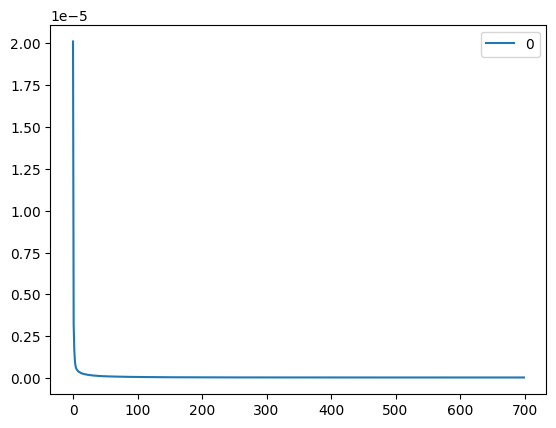

In [21]:
(pd.DataFrame(history.history['loss'])).plot()

In [22]:
tf_output = model.predict(preprocess(y_test))
tf_output = np.concatenate((tf_output[0],tf_output[1]),axis=1)

4110/4110 ━━━━━━━━━━━━━━━━━━━━ 3s 647us/step


In [23]:
pd.DataFrame(tf_output).to_csv('tmp.csv')

In [24]:
# tf_output = y_min_max_scaler.inverse_transform(tf_output)

In [25]:
arr = []

for i in range(len(tf_output)):
    arr.append(f'{tf_output[i][0]} + {tf_output[i][1]}i')


In [26]:
pd.Series(arr).to_csv('tf_model_output_test.csv',index=False,header=False)


In [27]:
import numpy as np
import scipy.io

# Function to parse complex numbers from the given format
def parse_complex_number(s):
    real, imag = s.split(' + ')
    real = float(real)
    imag = float(imag.replace('i', ''))
    return np.complex64(real + 1j * imag)

# Read the CSV file
filename = './tf_model_output_test.csv'  # Replace with your CSV filename
with open(filename, 'r') as file:
    lines = file.readlines()

# Parse the lines into complex numbers
complex_numbers = np.array([parse_complex_number(line.strip()) for line in lines], dtype=np.complex64)

# Save the array to a .mat file
output_filename = 'complex_data.mat'
scipy.io.savemat(output_filename, {'complex_data': complex_numbers})
